In [255]:
import numpy as np
import pandas as pd
import pylab as pl
import copy as cp
import string
import re

import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
pd.set_option('display.max_columns', None)

%matplotlib inline
import matplotlib.pyplot as plt

In [140]:
import warnings
warnings.filterwarnings('ignore')

In [141]:
data_path = "data/"

In [142]:
player_stat = pd.read_excel("players stat.xlsx")

In [143]:
player_cv = pd.read_excel("players cv.xlsx")

In [144]:
player_salary = pd.read_excel("players salary.xlsx")

# Season 2015-2016

In [145]:
player_stat_15_16 = player_stat[player_stat['Season'] == '2015-16']

In [146]:
player_salary_15_16 = player_salary[player_salary['SEASON'] == '2015-2016']

In [147]:
player_cv_15_16 = player_cv[(player_cv['From']<=2016) & (player_cv['To']>=2015)]

## Merge Stat and CV

In [148]:
merge_stat_cv = pd.merge(player_stat_15_16, player_cv_15_16, left_on='Player', right_on='Player', how='inner')

In [149]:
merge_stat_cv.shape

(470, 38)

## Merge Stat and CV and Salary

In [150]:
def preprocess_name(name):
    if ',' in name:
        ind = name.find(',')
        name = name[:ind]
    ### We remove the Jr.
    if "Jr." in name:
        name = name.replace("Jr.", "")
    if "Jr" in name:
        name = name.replace("Jr.", "")
    if "III" in name:
        name = name.replace("III", "")
    while '.' in name:
        ind = name.find('.')
        name = name.replace('.','')
    name = name.lower()
    
    return name

In [151]:
player_salary_15_16['Player'] = player_salary_15_16['NAME'].apply(lambda s: preprocess_name(s))

In [152]:
merge_stat_cv['Player'] = merge_stat_cv['Player'].apply(lambda s: preprocess_name(s))

In [153]:
len(set(merge_stat_cv['Player']))

470

In [154]:
merge = pd.merge(merge_stat_cv, player_salary_15_16, left_on='Player', right_on='Player', how='inner')

In [155]:
merge.shape

(377, 43)

## Final dataframe to work on for 2015-2016

In [156]:
merge.head(3)

,Player,Season,Age,Tm,Lg,G,GS,MP,PER,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Place_of_Birth,Race,From,To,Pos,Ht,Wt,Birth Date,College,SEASON,RK,NAME,TEAM,SALARY
0,thanasis antetokounmpo,2015-16,23.0,NYK,NBA,2,0.0,6.0,32.9,0.250,0.000,0.0,17.9,9.1,0.0,0.0,0.0,0.0,30.2,140.0,110.0,0.0,0.0,0.0,0.291,6.3,-10.5,-4.1,0.0,Greece,Black,2016,2016,F,6-7,205,"July 17, 1992",NaN,2015-2016,416,"Thanasis Antetokounmpo, SF",New York Knicks,30888
1,stephen curry,2015-16,27.0,GSW,NBA,79,79.0,2700.0,31.5,0.554,0.250,2.9,13.6,8.6,33.7,3.0,0.4,12.9,32.6,125.0,103.0,13.8,4.1,17.9,0.318,12.4,0.1,12.5,9.8,Ohio,Black and White,2010,2016,G,6-3,185,"March 14, 1988",Davidson College,2015-2016,55,"Stephen Curry, PG",Golden State Warriors,11370786
2,kevin durant,2015-16,27.0,OKC,NBA,72,72.0,2578.0,28.2,0.348,0.361,2.0,21.8,12.4,24.2,1.3,2.5,13.5,30.6,122.0,104.0,11.0,3.5,14.5,0.270,7.0,0.9,7.9,6.4,District of Columbia,Black,2008,2016,F,6-9,240,"September 29, 1988",University of Texas at Austin,2015-2016,7,"Kevin Durant, SF",Oklahoma City Thunder,20158622


## Dropping the repeated or not needed columns

The columns **NAME** and **SEASON** and **TEAM** are repeated twice so we can remove the duplicated columns. And since we're focusing only on the season 2015-2016 it's not relevant to keep this column at all. It's also no relevant to keep the column of the player's name or the league. They are play for the NBA 

In [276]:
M = cp.deepcopy(merge)
to_drop = ['Lg', 'NAME', 'Season', 'SEASON', 'TEAM']
M.drop(to_drop, axis=1, inplace=True)
M.head()

,Player,Age,Tm,G,GS,MP,PER,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Place_of_Birth,Race,From,To,Pos,Ht,Wt,Birth Date,College,RK,SALARY
0,thanasis antetokounmpo,23.0,NYK,2,0.0,6.0,32.9,0.250,0.000,0.0,17.9,9.1,0.0,0.0,0.0,0.0,30.2,140.0,110.0,0.0,0.0,0.0,0.291,6.3,-10.5,-4.1,0.0,Greece,Black,2016,2016,F,6-7,205,"July 17, 1992",NaN,416,30888
1,stephen curry,27.0,GSW,79,79.0,2700.0,31.5,0.554,0.250,2.9,13.6,8.6,33.7,3.0,0.4,12.9,32.6,125.0,103.0,13.8,4.1,17.9,0.318,12.4,0.1,12.5,9.8,Ohio,Black and White,2010,2016,G,6-3,185,"March 14, 1988",Davidson College,55,11370786
2,kevin durant,27.0,OKC,72,72.0,2578.0,28.2,0.348,0.361,2.0,21.8,12.4,24.2,1.3,2.5,13.5,30.6,122.0,104.0,11.0,3.5,14.5,0.270,7.0,0.9,7.9,6.4,District of Columbia,Black,2008,2016,F,6-9,240,"September 29, 1988",University of Texas at Austin,7,20158622
3,boban marjanovic,27.0,SAS,54,4.0,508.0,27.7,0.000,0.655,16.9,26.2,21.7,6.6,1.2,3.5,11.5,22.8,130.0,96.0,2.3,1.2,3.4,0.325,2.7,0.9,3.6,0.7,Russia,White,2016,2016,C,7-3,290,"August 15, 1988",NaN,315,1200000
4,russell westbrook,27.0,OKC,80,80.0,2750.0,27.6,0.236,0.397,6.1,18.1,12.4,49.6,2.9,0.6,16.8,31.6,115.0,103.0,10.0,4.0,14.0,0.245,7.6,2.4,10.0,8.3,California,Black,2009,2016,G,6-3,200,"November 12, 1988","University of California, Los Angeles",16,16744218


## Preprocessing

In [277]:
# Converting str valued columns to numerical columns
class CountOrdinalEncoder(OrdinalEncoder):
    """Encode categorical features as an integer array
    usint count information.
    """
    def __init__(self, categories='auto', dtype=np.float64):
        self.categories = categories
        self.dtype = dtype

    def fit(self, X, y=None):
        """Fit the OrdinalEncoder to X.

        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to determine the categories of each feature.

        Returns
        -------
        self
        """
        self.handle_unknown = 'use_encoded_value'
        self.unknown_value = np.nan
        super().fit(X)
        X_list, _, _ = self._check_X(X)
        # now we'll reorder by counts
        for k, cat in enumerate(self.categories_):
            counts = []
            for c in cat:
                counts.append(np.sum(X_list[k] == c))
            order = np.argsort(counts)
            self.categories_[k] = cat[order]
        return self

coe = CountOrdinalEncoder()
new_c = coe.fit_transform(pd.DataFrame(M['Tm']))
new_c = new_c.reshape(len(new_c),)
M.drop('Tm', axis=1, inplace=True)
M.insert(1, 'Tm', new_c)


# Converting height from feet to centimeters
def convert_height(height_str):
    foot, inches = height_str.split('-')
    height_cm = 30.48 * float(foot) + 2.54* float(inches) 
    return height_cm

new_c = np.array(M['Ht'].apply(convert_height))
new_c = new_c.reshape(len(new_c),)
M.drop('Ht', axis=1, inplace=True)
M.insert(32, 'Ht', new_c)

M.head()

# The "From" and "To" columns are redundant, we can just convert them to a column duration
duration = M['To'] - M['From']
M.insert(29, 'duration', duration)
M.drop('To', axis=1, inplace=True)
M.drop('From', axis=1, inplace=True)

M.head()

,Player,Tm,Age,G,GS,MP,PER,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Place_of_Birth,Race,duration,Pos,Ht,Wt,Birth Date,College,RK,SALARY
0,thanasis antetokounmpo,18.0,23.0,2,0.0,6.0,32.9,0.250,0.000,0.0,17.9,9.1,0.0,0.0,0.0,0.0,30.2,140.0,110.0,0.0,0.0,0.0,0.291,6.3,-10.5,-4.1,0.0,Greece,Black,0,F,200.66,205,"July 17, 1992",NaN,416,30888
1,stephen curry,19.0,27.0,79,79.0,2700.0,31.5,0.554,0.250,2.9,13.6,8.6,33.7,3.0,0.4,12.9,32.6,125.0,103.0,13.8,4.1,17.9,0.318,12.4,0.1,12.5,9.8,Ohio,Black and White,6,G,190.50,185,"March 14, 1988",Davidson College,55,11370786
2,kevin durant,17.0,27.0,72,72.0,2578.0,28.2,0.348,0.361,2.0,21.8,12.4,24.2,1.3,2.5,13.5,30.6,122.0,104.0,11.0,3.5,14.5,0.270,7.0,0.9,7.9,6.4,District of Columbia,Black,8,F,205.74,240,"September 29, 1988",University of Texas at Austin,7,20158622
3,boban marjanovic,9.0,27.0,54,4.0,508.0,27.7,0.000,0.655,16.9,26.2,21.7,6.6,1.2,3.5,11.5,22.8,130.0,96.0,2.3,1.2,3.4,0.325,2.7,0.9,3.6,0.7,Russia,White,0,C,220.98,290,"August 15, 1988",NaN,315,1200000
4,russell westbrook,17.0,27.0,80,80.0,2750.0,27.6,0.236,0.397,6.1,18.1,12.4,49.6,2.9,0.6,16.8,31.6,115.0,103.0,10.0,4.0,14.0,0.245,7.6,2.4,10.0,8.3,California,Black,7,G,190.50,200,"November 12, 1988","University of California, Los Angeles",16,16744218


In [278]:
# Encoding the race into a numerical value
pd.Categorical(M['Race']).categories

Index(['Black', 'Black and White', 'Others', 'White'], dtype='object')

We can use ordinal the count ordinal encoding like for the teams or just encoding it manually since there are only 4 categories for the race 

In [279]:
new_c = coe.fit_transform(pd.DataFrame(M['Race']))
new_c = new_c.reshape(len(new_c),)
M.drop('Race', axis=1, inplace=True)
M.insert(28, 'Race', new_c)

In [280]:
M.head()

,Player,Tm,Age,G,GS,MP,PER,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Place_of_Birth,Race,duration,Pos,Ht,Wt,Birth Date,College,RK,SALARY
0,thanasis antetokounmpo,18.0,23.0,2,0.0,6.0,32.9,0.250,0.000,0.0,17.9,9.1,0.0,0.0,0.0,0.0,30.2,140.0,110.0,0.0,0.0,0.0,0.291,6.3,-10.5,-4.1,0.0,Greece,3.0,0,F,200.66,205,"July 17, 1992",NaN,416,30888
1,stephen curry,19.0,27.0,79,79.0,2700.0,31.5,0.554,0.250,2.9,13.6,8.6,33.7,3.0,0.4,12.9,32.6,125.0,103.0,13.8,4.1,17.9,0.318,12.4,0.1,12.5,9.8,Ohio,1.0,6,G,190.50,185,"March 14, 1988",Davidson College,55,11370786
2,kevin durant,17.0,27.0,72,72.0,2578.0,28.2,0.348,0.361,2.0,21.8,12.4,24.2,1.3,2.5,13.5,30.6,122.0,104.0,11.0,3.5,14.5,0.270,7.0,0.9,7.9,6.4,District of Columbia,3.0,8,F,205.74,240,"September 29, 1988",University of Texas at Austin,7,20158622
3,boban marjanovic,9.0,27.0,54,4.0,508.0,27.7,0.000,0.655,16.9,26.2,21.7,6.6,1.2,3.5,11.5,22.8,130.0,96.0,2.3,1.2,3.4,0.325,2.7,0.9,3.6,0.7,Russia,2.0,0,C,220.98,290,"August 15, 1988",NaN,315,1200000
4,russell westbrook,17.0,27.0,80,80.0,2750.0,27.6,0.236,0.397,6.1,18.1,12.4,49.6,2.9,0.6,16.8,31.6,115.0,103.0,10.0,4.0,14.0,0.245,7.6,2.4,10.0,8.3,California,3.0,7,G,190.50,200,"November 12, 1988","University of California, Los Angeles",16,16744218


In [281]:
pd.Categorical(M['Place_of_Birth']).categories

Index(['Alabama', 'Alaska', 'Argentina', 'Arizona', 'Arkansas', 'Arkansas ',
       'Australia', 'Belgium', 'Bosnia and Herzegovina', 'Brazil',
       'California', 'California ', 'Canada', 'Cape Verde', 'Colorado',
       'Congo', 'Croatia', 'Democratic Republic of the Congo',
       'District of Columbia', 'Dominican Republic', 'Dominican Repulic',
       'Florida', 'France', 'French Guiana', 'Georgia', 'Georgia ', 'Germany',
       'Greece', 'Illinois', 'Illinois ', 'Indiana', 'Indiana ', 'Iowa',
       'Israel', 'Italy', 'Kansas', 'Kentucky', 'Kentucky ', 'Latvia',
       'Lithuania', 'Louisiana', 'Maryland', 'Maryland ', 'Massachusetts',
       'Mexico', 'Michigan', 'Minnesota', 'Mississippi', 'Mississippi ',
       'Missouri', 'Montenegro', 'New Jersey', 'New Mexico', 'New York',
       'New Zealand', 'New zealand', 'Nigeria', 'North Carolina',
       'North Carolina ', 'North Dakota', 'Ohio', 'Ohio ', 'Oklahoma',
       'Oregon', 'Pennsylvania', 'Pennsylvania ', 'Poland', 'Puert

There's a misspell in the name of **Wisconsin** that need to be corrected. Also, **Russia** and **Russian Federation** mean the same country so we need to correct it. We will add another column to specify if it's a state of the USA or an actual country. So we will add another categorical that takes 1 if the place of birth is a state of the USA and 0 if it's a country of the world.

In [282]:
# Changing Federation of Russia to Russia
indices = np.where(M['Place_of_Birth'] == "Russian Federation")[0]
M['Place_of_Birth'][indices] = "Russia"

# Correcting Wisconsin
indices = np.where(M['Place_of_Birth'] == "Wisvonsin")[0]
M['Place_of_Birth'][indices] = "Wisconsin"

In [283]:
states = ['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','Delaware','Florida','Georgia',
          'Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine','Maryland','Massachusetts',
          'Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska','Nevada','New Hampshire','New Jersey',
          'New Mexico','New York','North Carolina','North Dakota','Ohio','Oklahoma','Oregon','Pennsylvania','Rhode Island',
          'South Carolina','South Dakota','Tennessee','Texas','Utah','Vermont','Virginia','Washington','West Virginia',
          'Wisconsin','Wyoming']

In [284]:
state_or_country = list()
for elm in M['Place_of_Birth']:
    if elm in states:
        state_or_country.append(1)
    else:
        state_or_country.append(0)
M.insert(28,'state_or_country',state_or_country)

# We encode the place of birth by count ordinal encoding
new_c = coe.fit_transform(pd.DataFrame(M['Place_of_Birth']))
new_c = new_c.reshape(len(new_c),)
M.drop('Place_of_Birth', axis=1, inplace=True)
M.insert(27, 'Place_of_Birth', new_c)

In [285]:
M.head()

,Player,Tm,Age,G,GS,MP,PER,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Place_of_Birth,state_or_country,Race,duration,Pos,Ht,Wt,Birth Date,College,RK,SALARY
0,thanasis antetokounmpo,18.0,23.0,2,0.0,6.0,32.9,0.250,0.000,0.0,17.9,9.1,0.0,0.0,0.0,0.0,30.2,140.0,110.0,0.0,0.0,0.0,0.291,6.3,-10.5,-4.1,0.0,58.0,0,3.0,0,F,200.66,205,"July 17, 1992",NaN,416,30888
1,stephen curry,19.0,27.0,79,79.0,2700.0,31.5,0.554,0.250,2.9,13.6,8.6,33.7,3.0,0.4,12.9,32.6,125.0,103.0,13.8,4.1,17.9,0.318,12.4,0.1,12.5,9.8,93.0,1,1.0,6,G,190.50,185,"March 14, 1988",Davidson College,55,11370786
2,kevin durant,17.0,27.0,72,72.0,2578.0,28.2,0.348,0.361,2.0,21.8,12.4,24.2,1.3,2.5,13.5,30.6,122.0,104.0,11.0,3.5,14.5,0.270,7.0,0.9,7.9,6.4,55.0,0,3.0,8,F,205.74,240,"September 29, 1988",University of Texas at Austin,7,20158622
3,boban marjanovic,9.0,27.0,54,4.0,508.0,27.7,0.000,0.655,16.9,26.2,21.7,6.6,1.2,3.5,11.5,22.8,130.0,96.0,2.3,1.2,3.4,0.325,2.7,0.9,3.6,0.7,64.0,0,2.0,0,C,220.98,290,"August 15, 1988",NaN,315,1200000
4,russell westbrook,17.0,27.0,80,80.0,2750.0,27.6,0.236,0.397,6.1,18.1,12.4,49.6,2.9,0.6,16.8,31.6,115.0,103.0,10.0,4.0,14.0,0.245,7.6,2.4,10.0,8.3,95.0,1,3.0,7,G,190.50,200,"November 12, 1988","University of California, Los Angeles",16,16744218


In [286]:
print('All possible positions are:', list(pd.Categorical(M['Pos']).categories))

# Encoding positions
new_c = coe.fit_transform(pd.DataFrame(M['Pos']))
new_c = new_c.reshape(len(new_c),)
M.drop('Pos', axis=1, inplace=True)
M.insert(31, 'Pos', new_c)

All possible positions are: ['C', 'C-F', 'F', 'F-C', 'F-G', 'G', 'G-F']


In [287]:
M.head()

,Player,Tm,Age,G,GS,MP,PER,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Place_of_Birth,state_or_country,Race,duration,Pos,Ht,Wt,Birth Date,College,RK,SALARY
0,thanasis antetokounmpo,18.0,23.0,2,0.0,6.0,32.9,0.250,0.000,0.0,17.9,9.1,0.0,0.0,0.0,0.0,30.2,140.0,110.0,0.0,0.0,0.0,0.291,6.3,-10.5,-4.1,0.0,58.0,0,3.0,0,5.0,200.66,205,"July 17, 1992",NaN,416,30888
1,stephen curry,19.0,27.0,79,79.0,2700.0,31.5,0.554,0.250,2.9,13.6,8.6,33.7,3.0,0.4,12.9,32.6,125.0,103.0,13.8,4.1,17.9,0.318,12.4,0.1,12.5,9.8,93.0,1,1.0,6,6.0,190.50,185,"March 14, 1988",Davidson College,55,11370786
2,kevin durant,17.0,27.0,72,72.0,2578.0,28.2,0.348,0.361,2.0,21.8,12.4,24.2,1.3,2.5,13.5,30.6,122.0,104.0,11.0,3.5,14.5,0.270,7.0,0.9,7.9,6.4,55.0,0,3.0,8,5.0,205.74,240,"September 29, 1988",University of Texas at Austin,7,20158622
3,boban marjanovic,9.0,27.0,54,4.0,508.0,27.7,0.000,0.655,16.9,26.2,21.7,6.6,1.2,3.5,11.5,22.8,130.0,96.0,2.3,1.2,3.4,0.325,2.7,0.9,3.6,0.7,64.0,0,2.0,0,4.0,220.98,290,"August 15, 1988",NaN,315,1200000
4,russell westbrook,17.0,27.0,80,80.0,2750.0,27.6,0.236,0.397,6.1,18.1,12.4,49.6,2.9,0.6,16.8,31.6,115.0,103.0,10.0,4.0,14.0,0.245,7.6,2.4,10.0,8.3,95.0,1,3.0,7,6.0,190.50,200,"November 12, 1988","University of California, Los Angeles",16,16744218


In [288]:
print('All possible colleges are:', list(pd.Categorical(M['College']).categories))
print('\n\nNumber of colleges: ', len(list(pd.Categorical(M['College']).categories)))

All possible colleges are: ['Arizona State University', 'Baylor University', 'Blinn College', 'Boston College', 'Bowling Green State University', 'Brigham Young University', 'Butler University', 'California State University, Fresno', 'California State University, Long Beach', 'Central Michigan University', 'Clemson University', 'Cleveland State University', 'Colorado State University', 'Creighton University', 'Davidson College', 'Duke University', 'Eastern Washington University', 'Florida State University', 'Georgetown University', 'Georgia Institute of Technology', 'Georgia State University', 'Gonzaga University', 'Harvard University', 'Indiana University', 'Iowa State University', 'La Salle University', 'Lehigh University', 'Louisiana State University', 'Louisiana Tech University', 'Marquette University', 'Michigan State University', 'Morehead State University', 'Murray State University', 'Norfolk State University', 'North Carolina State University', 'Northeastern University', 'Ohio 

In [289]:
# Treating NAN values of this column
# We will just replace all this players of whom we don't have info about the college with "No college"      
M['College'][np.where(M['College'].isna() == True)[0]] = "No College"
new_c = coe.fit_transform(pd.DataFrame(M['College']))
new_c = new_c.reshape(len(new_c),)
M.drop('College', axis=1, inplace=True)
M.insert(34, 'College', new_c)

M.head()

,Player,Tm,Age,G,GS,MP,PER,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Place_of_Birth,state_or_country,Race,duration,Pos,Ht,Wt,College,Birth Date,RK,SALARY
0,thanasis antetokounmpo,18.0,23.0,2,0.0,6.0,32.9,0.250,0.000,0.0,17.9,9.1,0.0,0.0,0.0,0.0,30.2,140.0,110.0,0.0,0.0,0.0,0.291,6.3,-10.5,-4.1,0.0,58.0,0,3.0,0,5.0,200.66,205,103.0,"July 17, 1992",416,30888
1,stephen curry,19.0,27.0,79,79.0,2700.0,31.5,0.554,0.250,2.9,13.6,8.6,33.7,3.0,0.4,12.9,32.6,125.0,103.0,13.8,4.1,17.9,0.318,12.4,0.1,12.5,9.8,93.0,1,1.0,6,6.0,190.50,185,35.0,"March 14, 1988",55,11370786
2,kevin durant,17.0,27.0,72,72.0,2578.0,28.2,0.348,0.361,2.0,21.8,12.4,24.2,1.3,2.5,13.5,30.6,122.0,104.0,11.0,3.5,14.5,0.270,7.0,0.9,7.9,6.4,55.0,0,3.0,8,5.0,205.74,240,96.0,"September 29, 1988",7,20158622
3,boban marjanovic,9.0,27.0,54,4.0,508.0,27.7,0.000,0.655,16.9,26.2,21.7,6.6,1.2,3.5,11.5,22.8,130.0,96.0,2.3,1.2,3.4,0.325,2.7,0.9,3.6,0.7,64.0,0,2.0,0,4.0,220.98,290,103.0,"August 15, 1988",315,1200000
4,russell westbrook,17.0,27.0,80,80.0,2750.0,27.6,0.236,0.397,6.1,18.1,12.4,49.6,2.9,0.6,16.8,31.6,115.0,103.0,10.0,4.0,14.0,0.245,7.6,2.4,10.0,8.3,95.0,1,3.0,7,6.0,190.50,200,99.0,"November 12, 1988",16,16744218


For the moment we are going to the drop the columns of **Date of Birth** and **Name**. The column **Name** is useless and the column **Date of Birth** is redundant because we already have the age of each player stored in a column.

In [290]:
M.drop('Player', axis=1, inplace=True)
M.drop('Birth Date', axis=1, inplace=True)
M.drop('RK', axis=1, inplace=True)

M.head()

,Tm,Age,G,GS,MP,PER,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Place_of_Birth,state_or_country,Race,duration,Pos,Ht,Wt,College,SALARY
0,18.0,23.0,2,0.0,6.0,32.9,0.250,0.000,0.0,17.9,9.1,0.0,0.0,0.0,0.0,30.2,140.0,110.0,0.0,0.0,0.0,0.291,6.3,-10.5,-4.1,0.0,58.0,0,3.0,0,5.0,200.66,205,103.0,30888
1,19.0,27.0,79,79.0,2700.0,31.5,0.554,0.250,2.9,13.6,8.6,33.7,3.0,0.4,12.9,32.6,125.0,103.0,13.8,4.1,17.9,0.318,12.4,0.1,12.5,9.8,93.0,1,1.0,6,6.0,190.50,185,35.0,11370786
2,17.0,27.0,72,72.0,2578.0,28.2,0.348,0.361,2.0,21.8,12.4,24.2,1.3,2.5,13.5,30.6,122.0,104.0,11.0,3.5,14.5,0.270,7.0,0.9,7.9,6.4,55.0,0,3.0,8,5.0,205.74,240,96.0,20158622
3,9.0,27.0,54,4.0,508.0,27.7,0.000,0.655,16.9,26.2,21.7,6.6,1.2,3.5,11.5,22.8,130.0,96.0,2.3,1.2,3.4,0.325,2.7,0.9,3.6,0.7,64.0,0,2.0,0,4.0,220.98,290,103.0,1200000
4,17.0,27.0,80,80.0,2750.0,27.6,0.236,0.397,6.1,18.1,12.4,49.6,2.9,0.6,16.8,31.6,115.0,103.0,10.0,4.0,14.0,0.245,7.6,2.4,10.0,8.3,95.0,1,3.0,7,6.0,190.50,200,99.0,16744218


In [291]:
M.head()

,Tm,Age,G,GS,MP,PER,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Place_of_Birth,state_or_country,Race,duration,Pos,Ht,Wt,College,SALARY
0,18.0,23.0,2,0.0,6.0,32.9,0.250,0.000,0.0,17.9,9.1,0.0,0.0,0.0,0.0,30.2,140.0,110.0,0.0,0.0,0.0,0.291,6.3,-10.5,-4.1,0.0,58.0,0,3.0,0,5.0,200.66,205,103.0,30888
1,19.0,27.0,79,79.0,2700.0,31.5,0.554,0.250,2.9,13.6,8.6,33.7,3.0,0.4,12.9,32.6,125.0,103.0,13.8,4.1,17.9,0.318,12.4,0.1,12.5,9.8,93.0,1,1.0,6,6.0,190.50,185,35.0,11370786
2,17.0,27.0,72,72.0,2578.0,28.2,0.348,0.361,2.0,21.8,12.4,24.2,1.3,2.5,13.5,30.6,122.0,104.0,11.0,3.5,14.5,0.270,7.0,0.9,7.9,6.4,55.0,0,3.0,8,5.0,205.74,240,96.0,20158622
3,9.0,27.0,54,4.0,508.0,27.7,0.000,0.655,16.9,26.2,21.7,6.6,1.2,3.5,11.5,22.8,130.0,96.0,2.3,1.2,3.4,0.325,2.7,0.9,3.6,0.7,64.0,0,2.0,0,4.0,220.98,290,103.0,1200000
4,17.0,27.0,80,80.0,2750.0,27.6,0.236,0.397,6.1,18.1,12.4,49.6,2.9,0.6,16.8,31.6,115.0,103.0,10.0,4.0,14.0,0.245,7.6,2.4,10.0,8.3,95.0,1,3.0,7,6.0,190.50,200,99.0,16744218


## Data Analysis

In [292]:
# Only one line has Nan values, we'll drop it
ind = np.where(M['3PAr'].isna())[0]
M.drop(ind, axis=0, inplace=True)

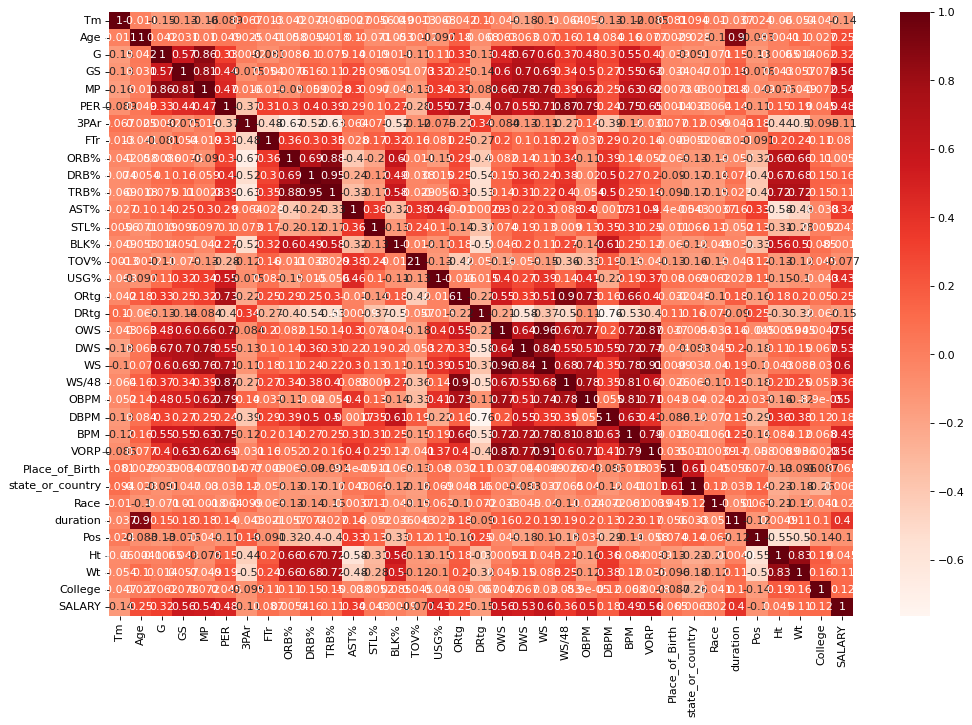

In [293]:
M[M.columns].corr()

plt.figure(figsize=(15, 10), dpi=80)
sns.heatmap(M[M.columns].corr(), annot=True, cmap = 'Reds')
plt.show()

The high correlations suggest that many of the columns contain redundant information, i.e. information from one column is contained in other columns. So if we will have the problems with the training of the model we can try to reduce this correlations for obtenir better results.

In [294]:
M1 = cp.deepcopy(M)

M1.drop('OWS', axis=1, inplace=True)
M1.drop('DWS', axis=1, inplace=True)
M1.drop('WS', axis=1, inplace=True)
M1.drop('WS/48', axis=1, inplace=True)
M1.drop('OBPM', axis=1, inplace=True)
M1.drop('DBPM', axis=1, inplace=True)
M1.drop('BPM', axis=1, inplace=True)
M1.drop('VORP', axis=1, inplace=True)

M1.head()

,Tm,Age,G,GS,MP,PER,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,Place_of_Birth,state_or_country,Race,duration,Pos,Ht,Wt,College,SALARY
0,18.0,23.0,2,0.0,6.0,32.9,0.250,0.000,0.0,17.9,9.1,0.0,0.0,0.0,0.0,30.2,140.0,110.0,58.0,0,3.0,0,5.0,200.66,205,103.0,30888
1,19.0,27.0,79,79.0,2700.0,31.5,0.554,0.250,2.9,13.6,8.6,33.7,3.0,0.4,12.9,32.6,125.0,103.0,93.0,1,1.0,6,6.0,190.50,185,35.0,11370786
2,17.0,27.0,72,72.0,2578.0,28.2,0.348,0.361,2.0,21.8,12.4,24.2,1.3,2.5,13.5,30.6,122.0,104.0,55.0,0,3.0,8,5.0,205.74,240,96.0,20158622
3,9.0,27.0,54,4.0,508.0,27.7,0.000,0.655,16.9,26.2,21.7,6.6,1.2,3.5,11.5,22.8,130.0,96.0,64.0,0,2.0,0,4.0,220.98,290,103.0,1200000
4,17.0,27.0,80,80.0,2750.0,27.6,0.236,0.397,6.1,18.1,12.4,49.6,2.9,0.6,16.8,31.6,115.0,103.0,95.0,1,3.0,7,6.0,190.50,200,99.0,16744218


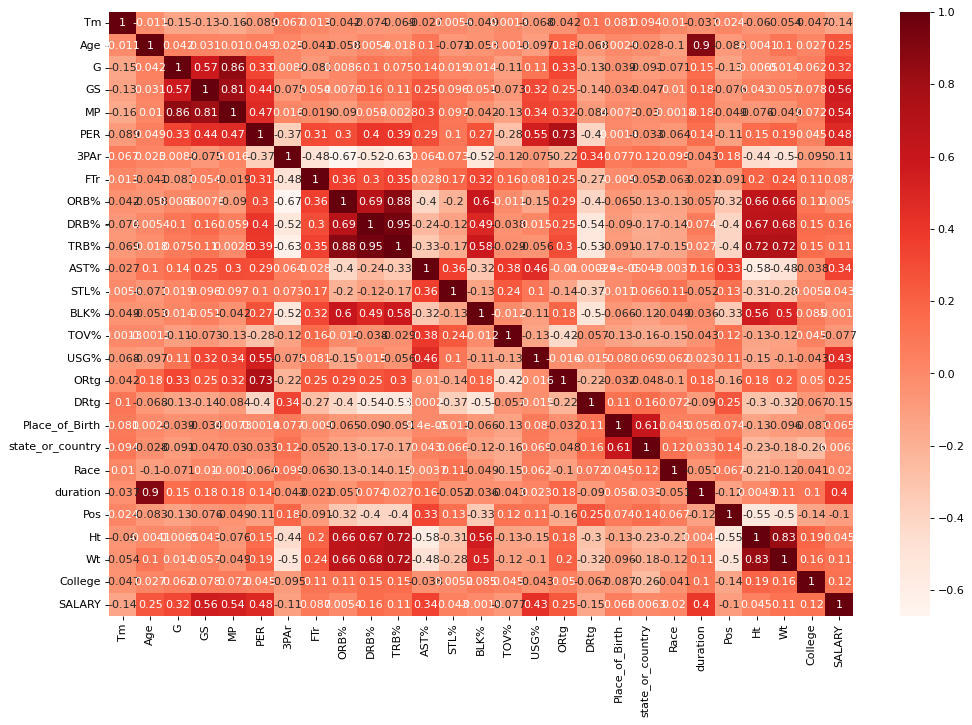

In [295]:
M1[M1.columns].corr()

plt.figure(figsize=(15, 10), dpi=80)
sns.heatmap(M1[M1.columns].corr(), annot=True, cmap = 'Reds')
plt.show()

The columns are seemingly more independant now.

## Spliting data

In [296]:
# Splitting into tagert and learning data
Y = cp.deepcopy(M1['SALARY'])
col = list(set((M1.columns))- set(['SALARY']))
X = cp.deepcopy(M1[col])

# Splitting into train and test data
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
Y_std = scaler.fit_transform(np.array(Y).reshape(-1,1)).reshape(len(Y),)

print(X_std.shape)
print(Y_std.shape)

X_train, X_test, y_train, y_test = train_test_split(X_std, Y_std, test_size=0.20, random_state=42)

(376, 26)
(376,)


## Model 1: Lasso Regression

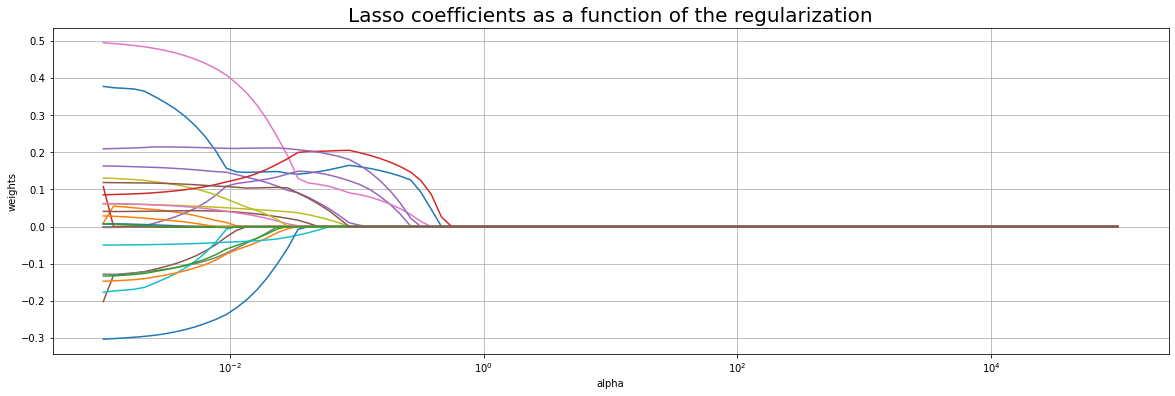

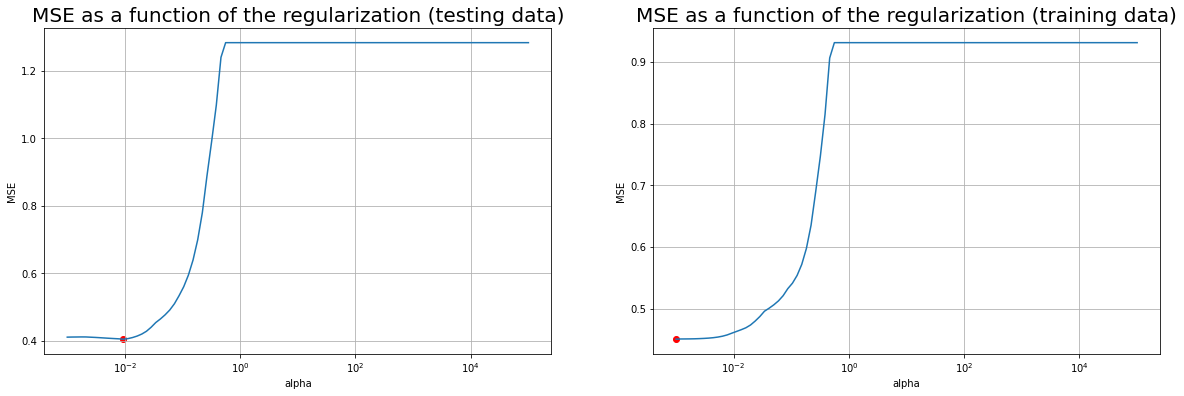

In [297]:
n_lasso = 100
weights_lasso, MSE_lasso, MSE_lasso_app = list(), list(), list()
alphas_lasso = np.logspace(-3, 5, n_lasso)
for a in alphas_lasso:
    lasso = Lasso(alpha = a)
    lasso.fit(X_train, y_train)
    weights_lasso.append(lasso.coef_)
    y = lasso.predict(X_test)
    y_app = lasso.predict(X_train)
    MSE_lasso.append(mean_squared_error(y, y_test))
    MSE_lasso_app.append(mean_squared_error(y_app, y_train))
weights_lasso = np.array(weights_lasso)

pl.figure(11, figsize=(20, 6))
ax = pl.gca()
for i in range(weights_lasso.shape[1]):
    ax.plot(alphas_lasso, weights_lasso[:,i])
ax.set_xscale('log')
pl.xlabel('alpha')
pl.ylabel('weights')
pl.title('Lasso coefficients as a function of the regularization', fontsize = 20)
pl.grid()
pl.axis('tight')

pl.figure(12, figsize=(20, 6))
pl.subplot(1,2,1)
ax = pl.gca()
ax.plot(alphas_lasso, MSE_lasso)
ax.scatter(alphas_lasso[np.argmin(MSE_lasso)], np.amin(MSE_lasso), c = 'red')
ax.set_xscale('log')
pl.xlabel('alpha')
pl.ylabel('MSE')
pl.title('MSE as a function of the regularization (testing data)', fontsize = 20)
pl.grid()
pl.axis('tight')
pl.subplot(1,2,2)
ax = pl.gca()
ax.plot(alphas_lasso, MSE_lasso_app)
ax.scatter(alphas_lasso[np.argmin(MSE_lasso_app)], np.amin(MSE_lasso_app), c = 'red')
ax.set_xscale('log')
pl.xlabel('alpha')
pl.ylabel('MSE')
pl.title('MSE as a function of the regularization (training data)', fontsize = 20)
pl.grid()
pl.axis('tight')
pl.show()

In [298]:
alpha_optim_lasso = alphas_lasso[np.argmin(MSE_lasso)]
model_lasso_optim = Lasso(alpha = alpha_optim_lasso)
model_lasso_optim.fit(X_train, y_train)
print("\nThe value of alpha that gives the smallest MSE score is: {}".format(np.round(alpha_optim_lasso,2)))


The value of alpha that gives the smallest MSE score is: 0.01


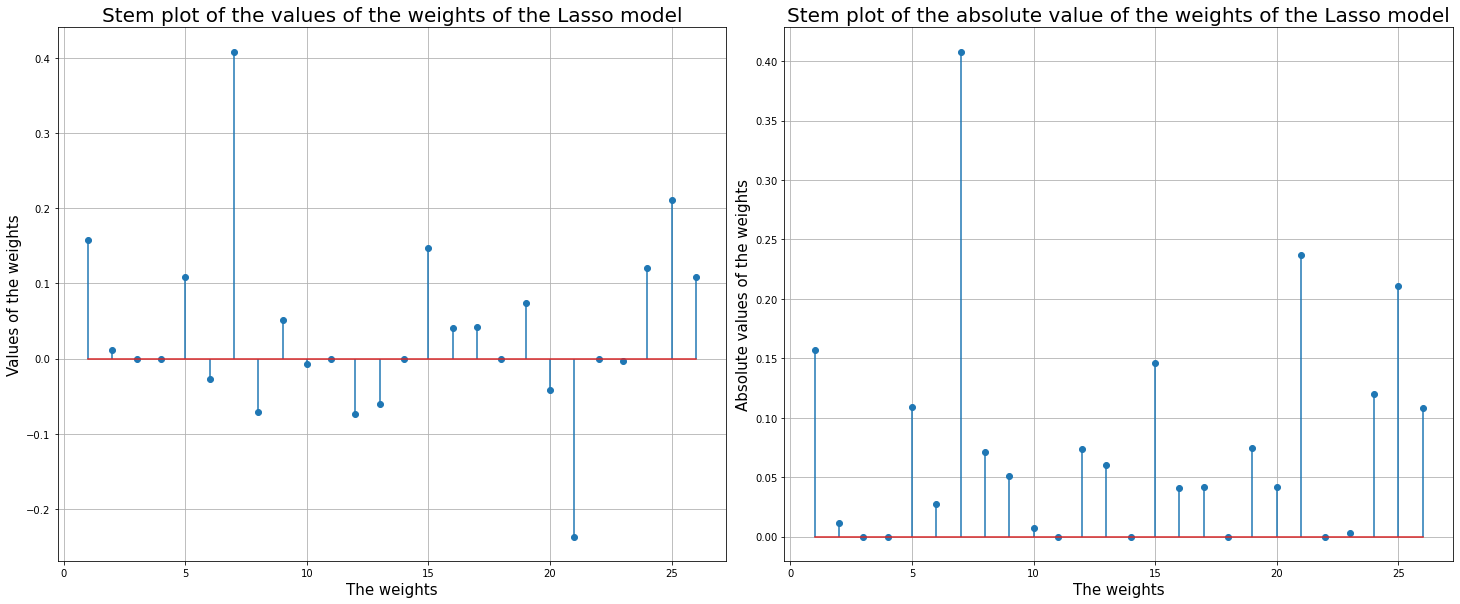

In [299]:
# Looking at the selection made by Lasso and use it to do variable selection and apply it to a non linear model
pl.figure(14, figsize = (20,8))
x = np.array([i+1 for i in range(model_lasso_optim.coef_.shape[0])])
pl.subplot(1,2,1)
pl.tight_layout(h_pad = 5, w_pad = 5)
pl.stem(x, model_lasso_optim.coef_, use_line_collection = True)
pl.title("Stem plot of the values of the weights of the Lasso model",fontsize=20)
pl.xlabel("The weights",fontsize=15)
pl.ylabel("Values of the weights",fontsize=15)
pl.grid()
pl.subplot(1,2,2)
pl.stem(x, np.abs(model_lasso_optim.coef_), use_line_collection = True)
pl.title("Stem plot of the absolute value of the weights of the Lasso model",fontsize=20)
pl.xlabel("The weights",fontsize=15)
pl.ylabel("Absolute values of the weights",fontsize=15)
pl.grid()

In [300]:
print('The variables of training are:\n', col)

The variables of training are:
 ['PER', 'ORB%', 'Age', 'TOV%', 'USG%', 'DRB%', 'MP', 'DRtg', 'College', 'ORtg', 'state_or_country', 'BLK%', 'STL%', 'TRB%', 'AST%', 'Place_of_Birth', 'Race', 'Pos', 'Ht', 'Tm', 'G', '3PAr', 'FTr', 'GS', 'duration', 'Wt']


In [301]:
y_predicted = model_lasso_optim.predict(X_test)
print("The R2 score is:", r2_score(y_test, y_predicted))
print("The MSE score is:", mean_squared_error(y_test, y_predicted))

The R2 score is: 0.6721609708697702
The MSE score is: 0.40443714509682405


## Model 2: XGBoost

In [302]:
model_rd = XGBRegressor()
model_rd.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [303]:
y_pred = model_rd.predict(X_test)
r2_score(y_test, y_pred)

0.7095647280329547